In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
from sklearn.metrics import mean_squared_error

In [3]:
### RUN ONLY TO CREATE 5FWY DATA ###
# partitions= ['wkday', 'wkend']
# years= [2008, 2009, 2010, 2011, 2013, 2014, 2015]

# station_meta_df= pd.read_json('./data/regression/station_meta.json', typ='frame', orient='records')
# m_fwy_meta_df= station_meta_df[station_meta_df.freeway == 5]
# m_fwy_meta_df= m_fwy_meta_df[['station', 'district']]
# m_fwy_meta_df.columns= ['S_ID', 'DISTRICT_ID']
# #
# for p in partitions:
#     for y in years:
#         a_df= pd.read_csv('./data/regression/trim_{}_{}.csv'.format(y, p), header=0)
#         desired_columns= ['S_ID'] + ['Flow_Coef_{}'.format(i) for i in xrange(1, 6)]
#         f_df= a_df[a_df.FWY_NUM == 5][desired_columns]
#         c_df= pd.merge(f_df, m_fwy_meta_df, on='S_ID')
#         c_df.to_csv('./data/5fwy_reconstruction/5fwy_{}_{}.csv'.format(y, p), index=False)

In [4]:
### RUN ONLY TO GATHER TEST SAMPLES FROM 5FWY FOR EACH DISTRICT ###
# import random as a_random

# partitions= ['wkday', 'wkend']
# years= [2008, 2009, 2010, 2011, 2013, 2014, 2015]

# m_tuples= []
# for p in partitions:
#     for y in years:
#         a_df= pd.read_csv('./data/5fwy_reconstruction/5fwy_{}_{}.csv'.format(y, p), header=0)
#         districts= [d for d in a_df.DISTRICT_ID.unique()]
#         for d_id in districts:
#             working_df= a_df[a_df.DISTRICT_ID == d_id]
#             stations= working_df.S_ID.unique()
#             num_sample= int(math.ceil(float(len(stations)) * 0.05))
#             sample= a_random.sample(stations, num_sample)
#             a_tuple= (y, p, d_id, sample)
#             m_tuples.append(a_tuple)


# selected_tuples= a_random.sample(m_tuples, 3)

# for y, p, d_id, sample in selected_tuples:
#     print(y, p, d_id, sample[0])

(2011, 'wkday', 7, 716985)
(2008, 'wkend', 3, 316096)
(2013, 'wkend', 6, 601310)

# Reconstruction on Top Eigenvectors with Normalized Root Mean Square Error - 5FWY

In [5]:
def set_xaxis(ax, n_x):
    x_ticks_major= []
    x_ticks_minor= []
    x_labels_minor= []
    x_labels_major= []
    m_empty_string= ''
    for i in xrange(n_x):
        m_time_minute= 5 * (i + 1)
        m_minute_string= '{}M'.format(m_time_minute).zfill(5)
        if m_time_minute % 60 == 0:
            m_hour= m_time_minute / 60
            m_hour_string= '{}H'.format(m_hour).zfill(3)
            x_ticks_major.append(float(i))
            x_labels_major.append(m_hour_string)
        else:
            x_ticks_minor.append(float(i))
            x_labels_minor.append(m_minute_string)
    ax.set_xticks(x_ticks_minor, minor=True)
    ax.set_xticks(x_ticks_major, minor=False)
    ax.set_xticklabels(x_labels_major, minor=False, rotation=65)
    ax.grid(True, which='major')
    ax.set_xlabel("time")
    ax.set_ylabel("veh/5m")

In [6]:
def get_reconstruction_from_projection(eigenvectors, Mean, m_projection):
    Eig= np.matrix(eigenvectors)
    rec = np.array(m_projection * Eig.transpose() + Mean)
    #rec= Eig*m_projection.transpose()+Mean[:,np.newaxis]
    return np.ravel(rec)

In [7]:
def display_reconstruction_from_projection(eigs, mean, m_projection, sample, label_format):
    rec= get_reconstruction_from_projection(eigs, mean, m_projection)

    fig, ax= plt.subplots(figsize=(16,8))
    ax.plot(rec, c='b', label='recon')
    ax.plot(sample, c='g', label='sample')
    #
    set_xaxis(ax, len(rec))
    #
    rmse= np.sqrt(mean_squared_error(sample, rec))
    rmse= rmse / (max(sample) - min(sample))
    label= label_format + '_NRMSE_{}'.format(rmse)
    ax.set_title(label)
    #
    ax.legend()

In [8]:
import random as a_random

def get_sample_reading(filepath):
    tdf= pd.read_csv(filepath, header=None)
    n= len(tdf)
    idx= a_random.randint(0, n)

    return tdf.iloc[idx].values[6:]

Processing p=weekend, y=2008, district=3, filepath=./data/5fwy_reconstruction/5fwy_2008_wkend.csv
Processing p=weekday, y=2011, district=7, filepath=./data/5fwy_reconstruction/5fwy_2011_wkday.csv
Processing p=weekend, y=2013, district=6, filepath=./data/5fwy_reconstruction/5fwy_2013_wkend.csv


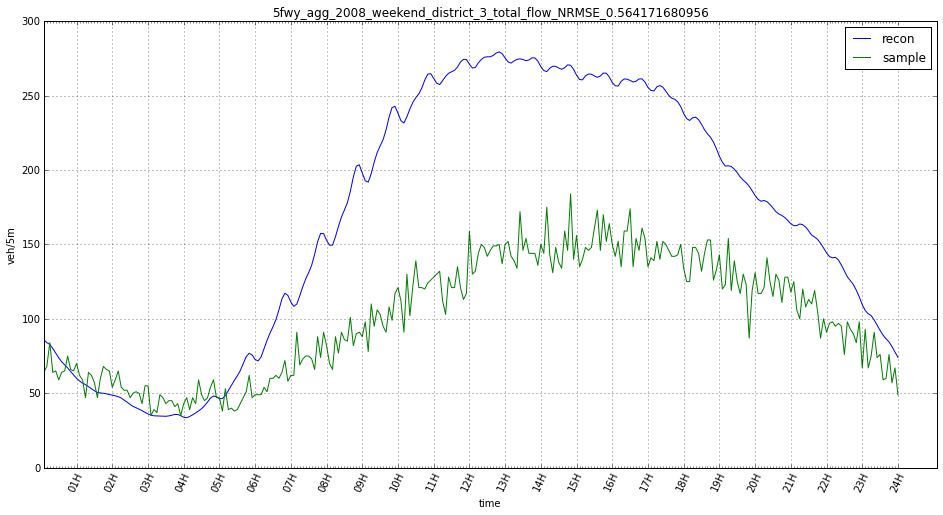

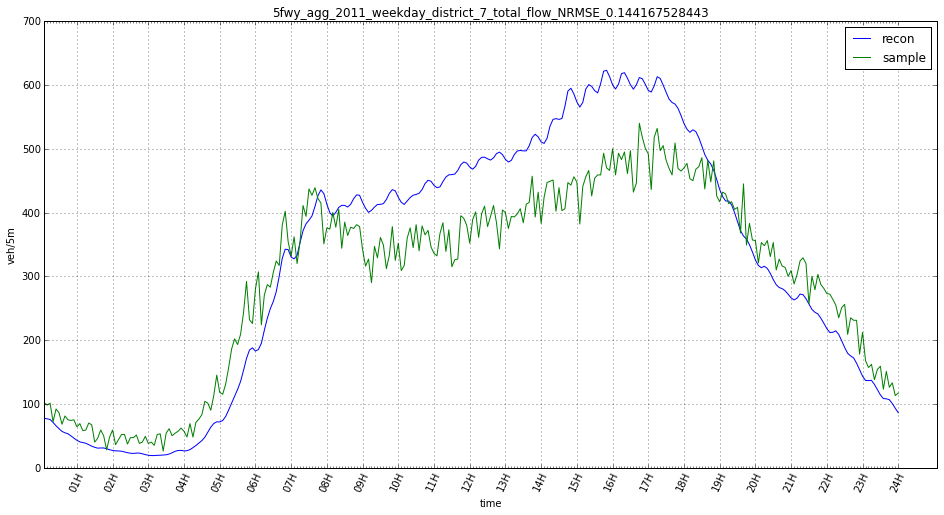

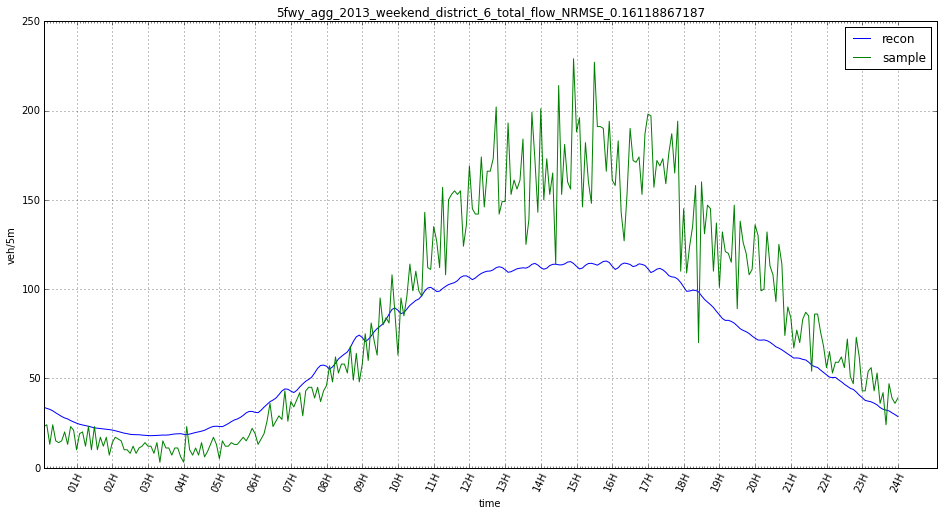

In [9]:
base_mean_path= './data/{}/total_flow_{}_mean_vector.pivot_{}_grouping_pca_tmp.csv'
base_eigs_path= './data/{}/total_flow_{}_eigenvectors.pivot_{}_grouping_pca_tmp.csv'
#
reconstructions= [
    ('weekend', 2008, 3, './data/5fwy_reconstruction/5fwy_2008_wkend.csv', './data/5fwy_reconstruction/total_flow_station_extract.weekend_station_extract_2008.csv'),
    ('weekday', 2011, 7, './data/5fwy_reconstruction/5fwy_2011_wkday.csv', './data/5fwy_reconstruction/total_flow_station_extract.weekday_station_extract_2011.csv'),
    ('weekend', 2013, 6, './data/5fwy_reconstruction/5fwy_2013_wkend.csv', './data/5fwy_reconstruction/total_flow_station_extract.weekend_station_extract_2013.csv')
]
flow_columns= ['Flow_Coef_{}'.format(i) for i in xrange(1, 6)]
desired_columns= ['DISTRICT_ID'] + flow_columns
#
for p, y, d_id, f_filepath, s_filepath in reconstructions:
    print('Processing p={}, y={}, district={}, filepath={}'.format(p, y, d_id, f_filepath))
    #
    mean = pd.read_csv(base_mean_path.format(p, p, y), header=None).values[0]
    eigs = pd.read_csv(base_eigs_path.format(p, p, y), header=None).values
    sample= get_sample_reading(s_filepath)
    #
    f_df = pd.read_csv(f_filepath, header=0)[desired_columns]
    f_df = f_df[f_df.DISTRICT_ID == d_id]
    working_df= f_df[flow_columns]
    f_avg= working_df.mean(axis=0).values

    label= '5fwy_agg_{}_{}_district_{}_total_flow'.format(y, p, d_id)
    display_reconstruction_from_projection(eigs, mean, f_avg, sample, label)